# 在现成库下计算AUC和ROC

In [1]:
import numpy as np  
from scipy import interp  
import matplotlib.pyplot as plt  
  
from sklearn import svm, datasets  
from sklearn.metrics import roc_curve, auc  
#from sklearn.cross_validation import StratifiedKFold  
from sklearn.model_selection import StratifiedKFold    #分层k折交叉验证

In [2]:
###############################################################################  
# Data IO and generation,导入iris数据，做数据准备  
  
# import some data to play with  
iris = datasets.load_iris()  
X = iris.data  
y = iris.target  

In [3]:
print(X)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [4]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [5]:
X, y = X[y != 2], y[y != 2]    #去掉了label为2，label只能二分，才可以。  
n_samples, n_features = X.shape  

In [7]:
print(n_samples,n_features)

100 4


In [6]:
# Add noisy features  
random_state = np.random.RandomState(0)  
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]  #将切片对象转换为按第二个轴连接

In [16]:
random_state.randn(n_samples, 200 * n_features).shape

(100, 800)

In [15]:
print(X.shape)

(100, 804)


所以上面的np.c_函数就是将X和噪音特征横向并在一起，得到新的X

In [19]:
###############################################################################  
# Classification and ROC analysis  
#分类，做ROC分析  
  
# Run classifier with cross-validation and plot ROC curves  
#使用6折交叉验证，并且画ROC曲线  
#cv = StratifiedKFold(y, n_folds=6) 
n_s = 5
cv = StratifiedKFold(n_splits=n_s)   #5折交叉验证
#cv.get_n_splits(y)
classifier = svm.SVC(kernel='linear', probability=True,    #构建分类器
                     random_state=random_state)#注意这里，probability=True,需要，不然预测的时候会出现异常。另外rbf核效果更好些。  
  
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)   #0-1分成100份
all_tpr = []  

d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy

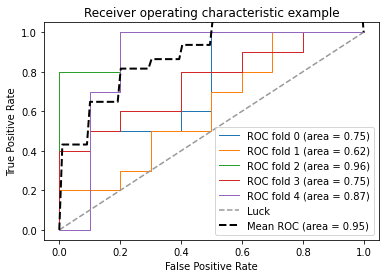

In [22]:
for i, (train, test) in enumerate(cv.split(X,y)):  
    #通过训练数据，使用svm线性核建立模型，并对测试集进行测试，求出预测得分  
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])  
#    print set(y[train])                     #set([0,1]) 即label有两个类别  
#    print len(X[train]),len(X[test])        #训练集有84个，测试集有16个  
#    print "++",probas_                      #predict_proba()函数输出的是测试集在lael各类别上的置信度，  
#    #在哪个类别上的置信度高，则分为哪类  

    # Compute ROC curve and area the curve  
    #通过roc_curve()函数，求出fpr和tpr，以及阈值thresholds 
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])   #fpr：假阳性率；tpr：真阳性率
    mean_tpr += interp(mean_fpr, fpr, tpr)          #mean_fpr是待插入数据的横坐标，相当于我用fpr和tpr建立回归函数，然后以mean_fpr为新的自变量，获得新的预测的y变量 
    mean_tpr[0] = 0.0                               #初始处为0  
    roc_auc = auc(fpr, tpr)  
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))  

#画对角线  
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  
  
#mean_tpr /= len(y)                     #在mean_fpr100个点，每个点处插值插值多次取平均  
mean_tpr /= n_s      
mean_tpr[-1] = 1.0                      #坐标最后一个点为（1,1）  
mean_auc = auc(mean_fpr, mean_tpr)      #计算平均AUC值  
#画平均ROC曲线  
#print mean_fpr,len(mean_fpr)  
#print mean_tpr  
plt.plot(mean_fpr, mean_tpr, 'k--',  
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)  
  
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right")  
plt.show()  

# 简单数据的例子

In [23]:
y = np.array([1,1,1,2,2,2])
pred = np.array([0.1,0.6,0.4,0.35,0.7,0.8])
fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.         0.66666667 0.66666667 1.        ]
[0.         0.33333333 0.66666667 0.66666667 1.         1.        ]
[1.8  0.8  0.7  0.4  0.35 0.1 ]


0.7777777777777778


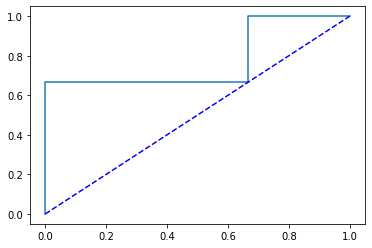

In [24]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], '--', color=(0, 0, 1))
plt.show()

In [25]:
a=[1]*50
b=[2]*50
y=np.array(a+b)   #y是真实地标签

prob_a = np.random.rand(50)*0.8
prob_b = 1-np.random.rand(50)*0.8
prob = np.array(list(prob_a)+list(prob_b))   #prob是假设模拟得到的预测结果
print(prob)

[0.63208819 0.72796493 0.23031656 0.03603117 0.14774209 0.77584897
 0.45180616 0.34457478 0.56415537 0.66717581 0.04159018 0.20991469
 0.78477151 0.70677294 0.61281257 0.19056219 0.57683545 0.67183794
 0.23450491 0.33239734 0.42287381 0.66979214 0.58503846 0.35080261
 0.50348266 0.10643096 0.46781188 0.32323854 0.37624103 0.57609368
 0.47935178 0.62643617 0.36300217 0.13718446 0.26416095 0.39018562
 0.60766869 0.25013682 0.46937123 0.58127292 0.00353362 0.70078513
 0.38828779 0.23466925 0.57330405 0.6661071  0.49032865 0.0764127
 0.35525194 0.52623751 0.51541955 0.40131937 0.88414664 0.90617268
 0.44287988 0.65134201 0.27313099 0.89365282 0.75938228 0.24354478
 0.52289291 0.31069234 0.60468162 0.70816234 0.35202313 0.42660398
 0.30436383 0.39917698 0.46558824 0.8806016  0.42521816 0.30785308
 0.86827818 0.83595323 0.60994166 0.43096726 0.77779121 0.93140554
 0.83695541 0.98000303 0.99467489 0.38080507 0.86602708 0.94413011
 0.20911235 0.98200466 0.98693149 0.58306261 0.39199446 0.21302

In [31]:
print(type(a))
print(b)
print(a+b)  # a+b不是数字加起来，而是横向排列。 因为a,b是列表不是数字
print(y)

<class 'list'>
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


[ 0.    0.    0.04  0.04  0.08  0.08  0.12  0.12  0.2   0.2   0.24  0.24
  0.26  0.26  0.36  0.36  0.38  0.38  0.4   0.4   0.5   0.5   0.52  0.52
  0.54  0.54  0.56  0.56  0.6   0.6   0.68  0.68  1.  ]
[ 0.02  0.42  0.42  0.46  0.46  0.5   0.5   0.54  0.54  0.62  0.62  0.66
  0.66  0.7   0.7   0.72  0.72  0.74  0.74  0.76  0.76  0.8   0.8   0.84
  0.84  0.9   0.9   0.94  0.94  0.96  0.96  1.    1.  ]
[ 0.97431794  0.77391122  0.76900811  0.75373959  0.72933347  0.72852786
  0.71877238  0.69740595  0.67939404  0.65829882  0.64271243  0.61493951
  0.59447466  0.59123576  0.50743256  0.49239093  0.49175411  0.48557423
  0.48139776  0.46829489  0.4225364   0.41388464  0.41033532  0.39216487
  0.38666679  0.35181304  0.3359938   0.31910479  0.30981776  0.30962194
  0.23464554  0.21225185  0.00954832]
0.7968


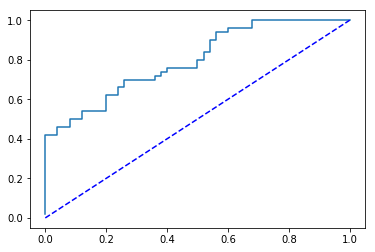

In [56]:
fpr, tpr, thresholds = roc_curve(y, prob, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)
print(auc(fpr, tpr))

plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], '--', color=(0, 0, 1))
plt.show()

# 利用pandas进行AUC和ROC的代码编写

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#测试样本的数量
parameter=40

In [33]:
data=pd.DataFrame(index=range(0,parameter),columns=('probability','The true label'))
data['The true label']=np.random.randint(0,2,size=len(data))
data['probability']=np.random.choice(np.arange(0.1,1,0.1),len(data['probability']))

In [34]:
print(data)  #查看得到的数据框    假设probability是得到的预测分类概率

    probability  The true label
0           0.6               0
1           0.2               0
2           0.6               1
3           0.2               1
4           0.5               1
5           0.6               0
6           0.9               0
7           0.2               0
8           0.4               1
9           0.9               0
10          0.7               0
11          0.5               0
12          0.8               0
13          0.5               0
14          0.1               1
15          0.3               1
16          0.3               1
17          0.4               1
18          0.6               0
19          0.9               1
20          0.6               1
21          0.2               1
22          0.7               0
23          0.2               0
24          0.4               1
25          0.8               0
26          0.5               0
27          0.9               1
28          0.8               0
29          0.2               0
30      

## 计算混淆矩阵

In [36]:
cm=np.arange(4).reshape(2,2)

cm[0,0]=len(data[data['The true label']==0][data['probability']<0.5]) #TN
cm[0,1]=len(data[data['The true label']==0][data['probability']>=0.5])#FP 假正例
cm[1,0]=len(data[data['The true label']==1][data['probability']<0.5]) #FN
cm[1,1]=len(data[data['The true label']==1][data['probability']>=0.5])#TP

d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [41]:
print(cm)

[[ 5 15]
 [13  7]]


## 计算假正率和真正率

真正例率=真正例/(真正例+假反例)；
假正例率=假正例/(假正例+真反例)

所以这里计算得真正例率=7/（7+13）;假正例率=15/（15+5）

## 绘制曲线

In [43]:
data.sort_values('probability',inplace=True,ascending=False)

在每个概率下计算真正例率和假正例率

In [46]:
TPRandFPR=pd.DataFrame(index=range(len(data)),columns=('TP','FP'))

for j in range(len(data)):
    data1=data.head(n=j+1)
    FP=len(data1[data1['The true label']==0] [data1['probability']>=data1.head(len(data1))['probability']])/float(len(data[data['The true label']==0]))
    
    TP=len(data1[data1['The true label']==1][data1['probability']>=data1.head(len(data1))['probability']])/float(len(data[data['The true label']==1])) 
    TPRandFPR.iloc[j]=[TP,FP]

d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\s

d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
d:\anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
d:\anaconda\anaconda3\envs\py37\lib\s

In [47]:
print(TPRandFPR)  #查看最后得到得结果

      TP    FP
0      0  0.05
1   0.05  0.05
2   0.05   0.1
3    0.1   0.1
4    0.1  0.15
5   0.15  0.15
6   0.15   0.2
7   0.15  0.25
8   0.15   0.3
9   0.15  0.35
10  0.15   0.4
11  0.15  0.45
12  0.15   0.5
13  0.15  0.55
14   0.2  0.55
15  0.25  0.55
16  0.25   0.6
17   0.3   0.6
18   0.3  0.65
19  0.35  0.65
20  0.35   0.7
21  0.35  0.75
22   0.4  0.75
23  0.45  0.75
24   0.5  0.75
25  0.55  0.75
26   0.6  0.75
27  0.65  0.75
28   0.7  0.75
29  0.75  0.75
30   0.8  0.75
31   0.8   0.8
32   0.8  0.85
33  0.85  0.85
34  0.85   0.9
35   0.9   0.9
36   0.9  0.95
37  0.95  0.95
38  0.95     1
39     1     1


画图

0.34500000000000003


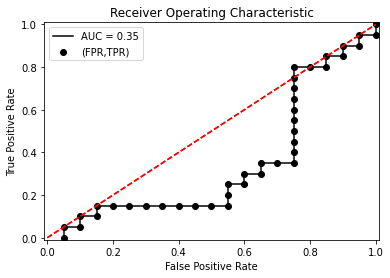

In [50]:
from sklearn.metrics import auc
AUC= auc(TPRandFPR['FP'],TPRandFPR['TP'])
print(AUC)

plt.scatter(x=TPRandFPR['FP'],y=TPRandFPR['TP'],label='(FPR,TPR)',color='k')
plt.plot(TPRandFPR['FP'], TPRandFPR['TP'], 'k',label='AUC = %0.2f'% AUC)
plt.legend(loc='upper left')

plt.title('Receiver Operating Characteristic')
plt.plot([(0,0),(1,1)],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,01.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()